# Аналитика по данным сервиса Яндекс.Недвижимость


Данные представляют собой объявления о продаже недвижимости и картографическую информацию к ним, нужно определить зависимость рыночной стоимости квартиры от различных факторов и определить параметры аномалий (мошеннических объявлений). 

Задачи:
- предоработка данных (заполнить пропуски, исправить ошибки, изменить тип данных)
- дополнение данных (добавить новые столбцы)
- категоризация данных 
- анализ корреляций и выявление зависимости рыночной цены квартиры от ее параметров 
- определение параметров аномалий


1. [Предварительный анализ данных](#1)
2. [Предобработка данных](#2)
3. [Дополнение данных](#3)
4. [Исследовательский анализ данных](#4)
5. [Общие выводы](#5)

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 40)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [108]:
#импорт данных
data = pd.read_csv('./eda_real_estate_data.csv', encoding = 'utf-8', sep = '\t')
data.head(5)

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,1564812,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,108.00,False,25.00,nan,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,nan
1,NaN,7,3350000.00,40.40,2018-12-04T00:00:00,1,nan,11.00,18.60,1,NaN,False,40.40,False,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,nan,0.00,nan,81.00
2,Сталинский,10,5196000.00,56.00,2015-08-20T00:00:00,2,nan,5.00,34.30,4,NaN,False,56.00,False,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,NaN,0,64900000.00,159.00,2015-07-24T00:00:00,3,nan,14.00,nan,9,NaN,False,159.00,False,nan,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,NaN,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,100.00,False,41.00,nan,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   building_series_id    6517 non-null   object 
 1   total_images          23699 non-null  int64  
 2   last_price            23699 non-null  float64
 3   total_area            23699 non-null  float64
 4   first_day_exposition  23699 non-null  object 
 5   rooms                 23699 non-null  int64  
 6   ceiling_height        14504 non-null  float64
 7   floors_total          23613 non-null  float64
 8   living_area           21796 non-null  float64
 9   floor                 23699 non-null  int64  
 10  is_apartment          2775 non-null   object 
 11  studio                23699 non-null  bool   
 12  area                  23699 non-null  float64
 13  open_plan             23699 non-null  bool   
 14  kitchen_area          21421 non-null  float64
 15  balcony            

# Предобработка данных  <a name="2"></a>

Задачи предобработки данных:
- проверка значений в колонках *total_area, rooms, living_area, floor, floors_total, kitchen_area, сeiling_height, airports_nearest, cityCenters_nearest* - что они не отрицательные и не равны нулю
- проверка соотношений между колонками про этажи и колонками про площади
- [заполнение пропусков](#2.1) *сeiling_height, living_area, kitchen_area, floors_total, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest, parks_around3000, parks_around3000, days_exposition*
- [смена типа данных](#2.2) с float на int: колонки *balcony, floors_total, parks_around3000, ponds_around3000, days_exposition* - это можно сделать только после того, как будут заполнены пропуски
- проверить, не осталось ли дубликатов

Для проверки значений в колонках *total_area, rooms, living_area, floor, floors_total, kitchen_area, сeiling_height, airports_nearest, cityCenters_nearest* на этом этапе достаточно убедиться, что числа целые и положительные, для этого подойдет метод value_counts или запрос query.

In [110]:
data['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64

In [111]:
#получилось 197 квартир с 0 комнатами, проверяем, студии ли это
len(data.query('rooms <=0 and studio == True'))

138

In [112]:
#или квартиры со свободной планировкой
len(data.query('rooms <=0 and open_plan == True'))

59

In [113]:
data['floor'].value_counts()

2     3368
3     3073
1     2917
4     2804
5     2621
6     1305
7     1218
8     1083
9     1051
10     687
12     526
11     523
13     379
15     343
14     337
16     315
17     227
18     178
19     147
21     125
22     113
20     110
23     100
24      63
25      46
26      24
27      10
28       1
33       1
29       1
30       1
32       1
31       1
Name: floor, dtype: int64

In [114]:
data['floors_total'].value_counts()

5.00     5788
9.00     3761
16.00    1376
12.00    1362
4.00     1200
10.00    1174
25.00    1075
6.00      914
17.00     833
3.00      668
7.00      592
14.00     553
18.00     505
24.00     469
8.00      390
2.00      383
15.00     365
23.00     352
19.00     339
22.00     286
20.00     271
13.00     229
11.00     203
27.00     164
21.00     158
26.00     124
1.00       25
35.00      24
28.00      21
36.00       3
29.00       1
60.00       1
33.00       1
52.00       1
37.00       1
34.00       1
Name: floors_total, dtype: int64

In [115]:
len(data.query('total_area <=0'))

0

In [116]:
len(data.query('ceiling_height <=0'))

0

In [117]:
len(data.query('living_area <=0'))

0

In [118]:
len(data.query('kitchen_area <=0'))

0

In [119]:
len(data.query('airports_nearest <=0'))

1

In [120]:
len(data.query('cityCenters_nearest <=0'))

0

Вот что получилось:
- есть 197 квартир с количеством комнат, равным нулю. 138 из них - это квартира-студия, 59 - квартиры со свободной планировкой, так что это нормальное значение.
- нет нулевых площадей или нулевых этажей или нулевой высоты потолка, это хорошо. Если вдруг придется заполнять пропуски нулями, можно это сделать, и они не смешаются с данными
- есть одна квартира прямо в аэропорту. Так не может быть, ее надо удалить.

In [121]:
#удаляем квартиру в аэропорту
data.drop(index = 21085, inplace = True)

Проверяем соотношения между колонками про этажи и колонками про площади: этаж в квартире не может быть больше общего количества этажей в доме, а общая площадь не может быть меньше жилой плюс кухонной.

In [122]:
len(data[data['floor'] > data['floors_total']])

0

In [123]:
data['living_kitchen_area'] = data ['living_area'] + data['kitchen_area']
len(data[data['total_area'] < data['living_kitchen_area']])

64

С этажами все хорошо, а вот с площадями - нет, есть целых 64 квартиры, у которых общая площадь меньше жилой плюс кухонной.
Вот это и есть первый параметр, по которым можно отслеживать мошеннические объявления, а пока их можно удалить.

In [124]:
#удаление строк в соответствии с логическим условием
data.drop((data[data['total_area'] < data['living_kitchen_area']]).index, inplace = True)
#проверка результата
len(data[data['total_area'] < data['living_kitchen_area']])

0

## Заполнение пропусков <a name="2.1"></a>

Отсутствующие значения есть в колонках: *сeiling_height, living_area, kitchen_area, floors_total, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_around3000, parks_nearest, ponds_nearest, days_exposition*

In [125]:
#отсутствующие значения в высоте потолков можно заменить на медиану
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

In [126]:
#чтобы правильно заполнить пропуски в жилой площади, посчитаем ее процент от общей
total_area_median = data['total_area'].median()
living_area_median = data['living_area'].median()
percent_living = living_area_median/total_area_median
data['living_area'] = data['living_area'].fillna(data['total_area']*percent_living)

#то же самое для площади кухни
kitchen_area_median = data['kitchen_area'].median()
percent_kitchen = kitchen_area_median/total_area_median

data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area']*percent_kitchen)

data.head(5)

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_kitchen_area
0,1564812,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,108.00,False,25.00,nan,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,nan,76.00
1,NaN,7,3350000.00,40.40,2018-12-04T00:00:00,1,2.65,11.00,18.60,1,NaN,False,40.40,False,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,nan,0.00,nan,81.00,29.60
2,Сталинский,10,5196000.00,56.00,2015-08-20T00:00:00,2,2.65,5.00,34.30,4,NaN,False,56.00,False,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00,42.60
3,NaN,0,64900000.00,159.00,2015-07-24T00:00:00,3,2.65,14.00,91.73,9,NaN,False,159.00,False,27.82,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00,nan
4,NaN,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,100.00,False,41.00,nan,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00,73.00


In [127]:
#чтобы отличить недозаполненные значения в floors_total от остальных, заменим на нули
#а этаж квартиры у этих объявлений потом пропишем как "другой", их всего 86 и это мало на что повлияет.
data['floors_total'] = data['floors_total'].fillna(0)

In [128]:
data.query('floors_total == 0')

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_kitchen_area
186,NaN,12,11640000.00,65.20,2018-10-02T00:00:00,2,2.65,0.00,30.80,4,NaN,False,65.20,False,12.00,nan,Санкт-Петербург,39197.00,12373.00,1.00,123.00,0.00,nan,49.00,42.80
237,NaN,4,2438033.00,28.10,2016-11-23T00:00:00,1,2.65,0.00,20.75,1,NaN,False,28.10,False,4.92,0.00,Санкт-Петербург,22041.00,17369.00,0.00,nan,1.00,374.00,251.00,nan
457,NaN,4,9788348.00,70.80,2015-08-01T00:00:00,2,2.65,0.00,38.40,12,NaN,False,70.80,False,10.63,0.00,Санкт-Петербург,37364.00,8322.00,2.00,309.00,2.00,706.00,727.00,49.03
671,NaN,4,6051191.00,93.60,2017-04-06T00:00:00,3,2.65,0.00,47.10,8,NaN,False,93.60,False,16.80,0.00,Санкт-Петербург,22041.00,17369.00,0.00,nan,1.00,374.00,123.00,63.90
1757,NaN,5,3600000.00,39.00,2017-04-22T00:00:00,1,2.65,0.00,22.50,9,NaN,False,39.00,False,6.82,0.00,Санкт-Петербург,22735.00,11618.00,1.00,835.00,1.00,652.00,77.00,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,1564812.0,5,8500000.00,63.50,2017-05-24T00:00:00,2,2.80,0.00,36.63,3,NaN,False,63.50,False,11.11,nan,Санкт-Петербург,51340.00,15363.00,0.00,nan,1.00,853.00,512.00,nan
22656,NaN,4,4574160.00,64.50,2017-04-02T00:00:00,2,2.65,0.00,31.70,20,NaN,False,64.50,False,14.40,0.00,Санкт-Петербург,22041.00,17369.00,0.00,nan,1.00,374.00,127.00,46.10
22808,NaN,0,14569263.00,110.40,2016-11-20T00:00:00,3,2.65,0.00,45.38,6,NaN,False,110.40,False,23.42,0.00,Санкт-Петербург,19095.00,4529.00,0.00,nan,0.00,nan,260.00,68.80
23590,NaN,0,21187872.00,123.30,2017-04-25T00:00:00,3,2.65,0.00,50.40,18,NaN,False,123.30,False,23.60,0.00,Санкт-Петербург,19095.00,4529.00,0.00,nan,0.00,nan,104.00,74.00


In [129]:
#с балконами проще всего -  пропущенные значения точно можно заменить на нули
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].unique()

array([0., 2., 1., 5., 4., 3.])

**Пропуски в картографических данных**

В колонках *airports_nearest, cityCenters_nearest, parks_around3000, parks_around3000* пропуски примерно в одних и тех же местах, и их довольно много - примерно 5500. 
Заполнить это, к сожалению, ничем нельзя, все будет очень неточно. В лучшем случае можно поделить данные на категории в зависимости от населенных пунктов и посчитать для них расстояния для аэропорта и центра, но это может занять очень много времени, и это все равно не поможет с колонками про парк и водоем. При исследовании зависимости цены от местоположения квартиры будем опираться на те данные, которые есть - отделим заполненные в этих колонках строки в от не заполненных.

Для столбца *locality_name* тоже нет смысла заполнять пропуски: их немного, и они ни на что не влияют.

Ситуация с колонками *parks_nearest, ponds_nearest* другая: там заполненных значений совсем немного. Это расстояния до ближайшего водоема или пруда. 

In [130]:
data.query('ponds_around3000 == 0')

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_kitchen_area
1,NaN,7,3350000.00,40.40,2018-12-04T00:00:00,1,2.65,11.00,18.60,1,NaN,False,40.40,False,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,nan,0.00,nan,81.00,29.60
6,NaN,6,3700000.00,37.30,2017-11-02T00:00:00,1,2.65,26.00,10.60,6,NaN,False,37.30,False,14.40,1.00,посёлок Парголово,52996.00,19143.00,0.00,nan,0.00,nan,155.00,25.00
7,NaN,5,7915000.00,71.60,2019-04-18T00:00:00,2,2.65,24.00,41.31,22,NaN,False,71.60,False,18.90,2.00,Санкт-Петербург,23982.00,11634.00,0.00,nan,0.00,nan,nan,nan
9,NaN,18,5400000.00,61.00,2017-02-26T00:00:00,3,2.50,9.00,43.60,7,NaN,False,61.00,False,6.50,2.00,Санкт-Петербург,50898.00,15008.00,0.00,nan,0.00,nan,289.00,50.10
11,NaN,9,3300000.00,44.00,2018-08-27T00:00:00,2,2.65,5.00,31.00,4,False,False,44.00,False,6.00,1.00,Ломоносов,48252.00,51677.00,0.00,nan,0.00,nan,7.00,37.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23684,1564812.0,20,21400000.00,145.00,2018-11-02T00:00:00,4,3.00,26.00,71.40,17,NaN,False,145.00,False,15.60,0.00,Санкт-Петербург,11827.00,11459.00,0.00,nan,0.00,nan,nan,87.00
23685,1568627.0,15,2490000.00,31.00,2019-01-24T00:00:00,1,2.50,5.00,17.30,5,NaN,False,31.00,False,5.60,1.00,Ломоносов,48393.00,51818.00,0.00,nan,0.00,nan,nan,22.90
23687,NaN,6,3200000.00,39.00,2017-12-16T00:00:00,1,2.65,9.00,20.00,6,NaN,False,39.00,False,11.00,2.00,Санкт-Петербург,40837.00,16704.00,0.00,nan,0.00,nan,38.00,31.00
23688,1564812.0,19,9200000.00,101.00,2019-04-01T00:00:00,3,3.05,15.00,63.00,12,NaN,False,101.00,False,15.00,0.00,Санкт-Петербург,15632.00,14428.00,0.00,nan,0.00,nan,23.00,78.00


In [131]:
data.query('parks_around3000 == 0')

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_kitchen_area
1,NaN,7,3350000.00,40.40,2018-12-04T00:00:00,1,2.65,11.00,18.60,1,NaN,False,40.40,False,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,nan,0.00,nan,81.00,29.60
6,NaN,6,3700000.00,37.30,2017-11-02T00:00:00,1,2.65,26.00,10.60,6,NaN,False,37.30,False,14.40,1.00,посёлок Парголово,52996.00,19143.00,0.00,nan,0.00,nan,155.00,25.00
7,NaN,5,7915000.00,71.60,2019-04-18T00:00:00,2,2.65,24.00,41.31,22,NaN,False,71.60,False,18.90,2.00,Санкт-Петербург,23982.00,11634.00,0.00,nan,0.00,nan,nan,nan
9,NaN,18,5400000.00,61.00,2017-02-26T00:00:00,3,2.50,9.00,43.60,7,NaN,False,61.00,False,6.50,2.00,Санкт-Петербург,50898.00,15008.00,0.00,nan,0.00,nan,289.00,50.10
11,NaN,9,3300000.00,44.00,2018-08-27T00:00:00,2,2.65,5.00,31.00,4,False,False,44.00,False,6.00,1.00,Ломоносов,48252.00,51677.00,0.00,nan,0.00,nan,7.00,37.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23684,1564812.0,20,21400000.00,145.00,2018-11-02T00:00:00,4,3.00,26.00,71.40,17,NaN,False,145.00,False,15.60,0.00,Санкт-Петербург,11827.00,11459.00,0.00,nan,0.00,nan,nan,87.00
23685,1568627.0,15,2490000.00,31.00,2019-01-24T00:00:00,1,2.50,5.00,17.30,5,NaN,False,31.00,False,5.60,1.00,Ломоносов,48393.00,51818.00,0.00,nan,0.00,nan,nan,22.90
23687,NaN,6,3200000.00,39.00,2017-12-16T00:00:00,1,2.65,9.00,20.00,6,NaN,False,39.00,False,11.00,2.00,Санкт-Петербург,40837.00,16704.00,0.00,nan,0.00,nan,38.00,31.00
23688,1564812.0,19,9200000.00,101.00,2019-04-01T00:00:00,3,3.05,15.00,63.00,12,NaN,False,101.00,False,15.00,0.00,Санкт-Петербург,15632.00,14428.00,0.00,nan,0.00,nan,23.00,78.00


Получается, что если пруда или водоема в радиусе трех километров не нашлось, то эта колонка не заполнялась. Тогда можно проставить нули там, где нашлось ноль парков и водоемов, и оставить пропуски там, где картографических данных нет совсем.

In [132]:
data.loc[data['parks_around3000'] == 0, 'parks_nearest'] = 0
data.loc[data['ponds_around3000'] == 0, 'ponds_nearest'] = 0
#проверяем, что число пропущенных значений во всех четырех колонках совпало
data.head()

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_kitchen_area
0,1564812,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,108.00,False,25.00,0.00,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,nan,76.00
1,NaN,7,3350000.00,40.40,2018-12-04T00:00:00,1,2.65,11.00,18.60,1,NaN,False,40.40,False,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,0.00,0.00,0.00,81.00,29.60
2,Сталинский,10,5196000.00,56.00,2015-08-20T00:00:00,2,2.65,5.00,34.30,4,NaN,False,56.00,False,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00,42.60
3,NaN,0,64900000.00,159.00,2015-07-24T00:00:00,3,2.65,14.00,91.73,9,NaN,False,159.00,False,27.82,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00,nan
4,NaN,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,100.00,False,41.00,0.00,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00,73.00


In [133]:
#чтобы заполнить пропущенные значения в days_exposition, нужно посмотреть на разброс данных
data['days_exposition'].describe()

count   20461.00
mean      180.96
std       219.80
min         1.00
25%        45.00
50%        95.00
75%       232.00
max      1580.00
Name: days_exposition, dtype: float64

In [134]:
#лучше заменить на медианное значение, очень большая разница между средним и медианой
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())

## Смена типа данных <a name="2.2"></a>

с float на int: колонки *balcony, floors_total, days_exposition*. Для колонок *parks_around3000, ponds_around3000* пропуски остались, значит, и тип данных останется как есть.

In [135]:
data['balcony'] = data['balcony'].astype('int64')
data['floors_total'] = data['floors_total'].astype('int64')
data['days_exposition'] = data['days_exposition'].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23634 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   building_series_id    6507 non-null   object 
 1   total_images          23634 non-null  int64  
 2   last_price            23634 non-null  float64
 3   total_area            23634 non-null  float64
 4   first_day_exposition  23634 non-null  object 
 5   rooms                 23634 non-null  int64  
 6   ceiling_height        23634 non-null  float64
 7   floors_total          23634 non-null  int64  
 8   living_area           23634 non-null  float64
 9   floor                 23634 non-null  int64  
 10  is_apartment          2758 non-null   object 
 11  studio                23634 non-null  bool   
 12  area                  23634 non-null  float64
 13  open_plan             23634 non-null  bool   
 14  kitchen_area          23634 non-null  float64
 15  balcony            

In [136]:
#проверяем, не осталось ли дубликатов
data.duplicated().sum()

0

In [137]:
#удаляем уже ненужные столбцы
data.drop(['living_kitchen_area'], axis = 1, inplace = True)
#data.drop(['area'], axis = 1, inplace = True)
data.head()

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,1564812,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16,51.00,8,NaN,False,108.00,False,25.00,0,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,95
1,NaN,7,3350000.00,40.40,2018-12-04T00:00:00,1,2.65,11,18.60,1,NaN,False,40.40,False,11.00,2,посёлок Шушары,12817.00,18603.00,0.00,0.00,0.00,0.00,81
2,Сталинский,10,5196000.00,56.00,2015-08-20T00:00:00,2,2.65,5,34.30,4,NaN,False,56.00,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558
3,NaN,0,64900000.00,159.00,2015-07-24T00:00:00,3,2.65,14,91.73,9,NaN,False,159.00,False,27.82,0,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424
4,NaN,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14,32.00,13,NaN,False,100.00,False,41.00,0,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121


In [138]:
data.loc[data['locality_name'] == 'Кудрово', 'locality_name'] = 'деревня Кудрово'
data['locality_name'].value_counts()

Санкт-Петербург           15681
посёлок Мурино              520
деревня Кудрово             472
посёлок Шушары              439
Всеволожск                  395
                          ...  
деревня Борисова Грива        1
деревня Каськово              1
поселок Гладкое               1
посёлок Левашово              1
деревня Курковицы             1
Name: locality_name, Length: 363, dtype: int64

# Дополнение данных <a name="3"></a>

Нужно посчитать и добавить в таблицу:
- цену квадратного метра;
- день недели, месяц и год публикации объявления;
- этаж, на котором расположена квартира; варианты — первый, последний, другой;
- соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [139]:
#подсчет цены за квадратный метр
data['meter_price'] = data['last_price'] / data['total_area']
data.head()

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price
0,1564812,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16,51.00,8,NaN,False,108.00,False,25.00,0,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,95,120370.37
1,NaN,7,3350000.00,40.40,2018-12-04T00:00:00,1,2.65,11,18.60,1,NaN,False,40.40,False,11.00,2,посёлок Шушары,12817.00,18603.00,0.00,0.00,0.00,0.00,81,82920.79
2,Сталинский,10,5196000.00,56.00,2015-08-20T00:00:00,2,2.65,5,34.30,4,NaN,False,56.00,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558,92785.71
3,NaN,0,64900000.00,159.00,2015-07-24T00:00:00,3,2.65,14,91.73,9,NaN,False,159.00,False,27.82,0,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424,408176.10
4,NaN,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14,32.00,13,NaN,False,100.00,False,41.00,0,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121,100000.00


In [140]:
#приведение даты и времени к читаемому формату
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
#новые колонки с годом, месяцем и днем недели публикации объявления
data['year'] = data['first_day_exposition'].dt.year
data['month'] = data['first_day_exposition'].dt.month
data['weekday'] = data['first_day_exposition'].dt.weekday

data.head()

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,year,month,weekday
0,1564812,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,NaN,False,108.00,False,25.00,0,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,95,120370.37,2019,3,3
1,NaN,7,3350000.00,40.40,2018-12-04,1,2.65,11,18.60,1,NaN,False,40.40,False,11.00,2,посёлок Шушары,12817.00,18603.00,0.00,0.00,0.00,0.00,81,82920.79,2018,12,1
2,Сталинский,10,5196000.00,56.00,2015-08-20,2,2.65,5,34.30,4,NaN,False,56.00,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558,92785.71,2015,8,3
3,NaN,0,64900000.00,159.00,2015-07-24,3,2.65,14,91.73,9,NaN,False,159.00,False,27.82,0,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424,408176.10,2015,7,4
4,NaN,2,10000000.00,100.00,2018-06-19,2,3.03,14,32.00,13,NaN,False,100.00,False,41.00,0,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121,100000.00,2018,6,1


In [141]:
#новая колонка floor_category, если floor = 1 - это первый этаж
data.loc[data['floor'] == 1, 'floor_category'] = 'Первый'
#если этаж, на котором квартира, равен числу этажей в доме - он последний
data.loc[data['floor'] == data['floors_total'], 'floor_category'] = 'Последний'
#остальные - другие этажи
data['floor_category'] = data['floor_category'].fillna('Другой')
data['floor_category'].value_counts()

Другой       17399
Последний     3347
Первый        2888
Name: floor_category, dtype: int64

In [142]:
#доля жилой площади от общей
data['living_ratio'] = data['living_area']/data['total_area']
#процентный формат
#data['living_ratio'] = data['living_ratio'].map(lambda n: '{:,.2%}'.format(n))
#доля площади кухни от общей
data['kitchen_ratio'] = data['kitchen_area']/data['total_area']
#процентный формат
#data['kitchen_ratio'] = data['kitchen_ratio'].map(lambda n: '{:,.2%}'.format(n))

data.head()

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,year,month,weekday,floor_category,living_ratio,kitchen_ratio
0,1564812,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,NaN,False,108.00,False,25.00,0,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,95,120370.37,2019,3,3,Другой,0.47,0.23
1,NaN,7,3350000.00,40.40,2018-12-04,1,2.65,11,18.60,1,NaN,False,40.40,False,11.00,2,посёлок Шушары,12817.00,18603.00,0.00,0.00,0.00,0.00,81,82920.79,2018,12,1,Первый,0.46,0.27
2,Сталинский,10,5196000.00,56.00,2015-08-20,2,2.65,5,34.30,4,NaN,False,56.00,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558,92785.71,2015,8,3,Другой,0.61,0.15
3,NaN,0,64900000.00,159.00,2015-07-24,3,2.65,14,91.73,9,NaN,False,159.00,False,27.82,0,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424,408176.10,2015,7,4,Другой,0.58,0.17
4,NaN,2,10000000.00,100.00,2018-06-19,2,3.03,14,32.00,13,NaN,False,100.00,False,41.00,0,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121,100000.00,2018,6,1,Другой,0.32,0.41


# Исследовательский анализ данных <a name="4"></a>

Исследовательский анализ будем проводить по отдельным темам.
Посмотрим, как распределяются следующие параметры, удалим выбивающиеся данные и найдем корреляции с другими параметрами:
- [общая площадь в соотношении с количеством комнат](#4.1)
- [соотношение жилой, кухонной и общей площади квартир](#4.2)
- [стоимость квартир и стоимость квадратного метра](#4.3)
- [расстояние от центра и аэропорта](#4.4)
    - [квартиры в пригородах](#4.4.1)
    - [сегменты квартир в центре и вне центра](#4.4.2)
- [даты размещения объявления и длительность процесса продажи](#4.5)
- [студии, апартаменты, квартиры со свободной планировкой](#4.6)

## Общая площадь в соотношении с количеством комнат <a name="4.1"></a>

In [143]:
#смотрим, как распеределяются данные по общей площади квартир
data['total_area'].describe()

count   23634.00
mean       60.38
std        35.69
min        12.00
25%        40.00
50%        52.00
75%        70.00
max       900.00
Name: total_area, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000249DE1E3C08>]],
      dtype=object)

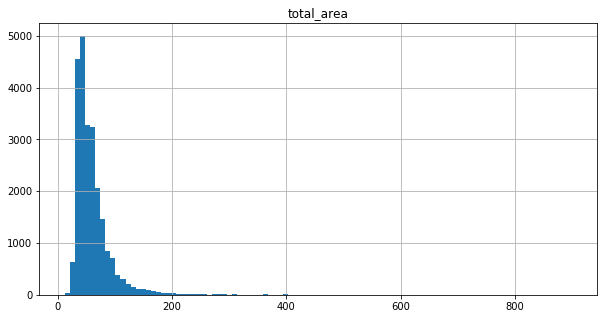

In [144]:
data.hist('total_area', bins = 100, figsize = (10,5))

Очень длинный хвост, и есть очень маленькие значения - меньше 20 квадратных метров. Про маленькие будем считать, что это коммуналки. 
Основная масса значений умещается в диапазон от 0 до 200. Посмотрим, можно ли срезать все, что больше 200, и категоризировать оставшееся. Для этого посчитаем, сколько всего квартир площадью больше 200 кв.м., если немного - то их можно удалить.

In [145]:
data.query('total_area > 200 and last_price > 20000000')['last_price'].count()

185

In [146]:
#удаление строк в соответствии с логическим условием
data.drop((data[data['total_area'] > 200]).index, inplace = True)
data['total_area'].describe()

count   23407.00
mean       58.21
std        26.55
min        12.00
25%        40.00
50%        52.00
75%        69.00
max       200.00
Name: total_area, dtype: float64

227 квартир площадью больше 200 кв м - это менее одного процента всего датасета, их можно выбросить. После удаления среднее упало с 60 до 58, а медиана осталась равной 52.

Я проверила, что будет, если удалить больше (например, все квартиры площадью больше 150 или 125) - тогда медиана меняет значение на меньшее, т.е. распределение меняется, поэтому остановимся на верхнем пределе общей площади в 200 кв.м.

Посмотрим сразу на комнаты и площади вместе - как они распределяются, и в соответствии с этим поделим площади квартир на категории.

In [147]:
#какие есть варианты количества комнат
data['rooms'].value_counts()

1     8014
2     7918
3     5788
4     1140
5      265
0      196
6       62
7       20
11       2
8        2
Name: rooms, dtype: int64

До удаления выбивающихся значений были еще квартиры с 15, 16 и 19 комнатами. Можно удалить еще 8 и 11 комнат.

In [148]:
#удаление строк в соответствии с логическим условием
data.drop((data[data['rooms'] > 7]).index, inplace = True)
data['rooms'].value_counts()

1    8014
2    7918
3    5788
4    1140
5     265
0     196
6      62
7      20
Name: rooms, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000249DE2542C8>]],
      dtype=object)

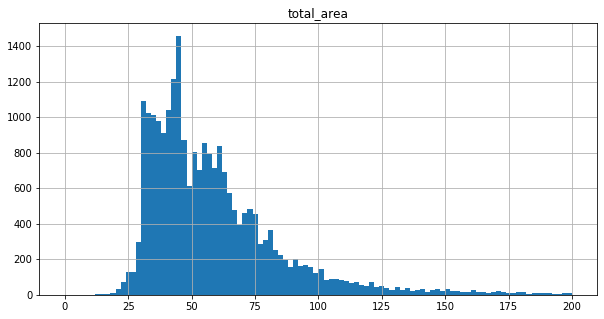

In [149]:
#посмотрим, как будет выглядеть гистограмма общей площади с менее длинным хвостом
data.hist('total_area', bins = 100, range = (0,200), figsize = (10,5))

Чтобы затем работать с обобщенными данными по площадям квартир, поделим их на категории. Просто разделить на квартили кажется неправильным. Чтобы правильно распределить категории площади, посмотрим, какая площадь какому количеству комнат соответствует.

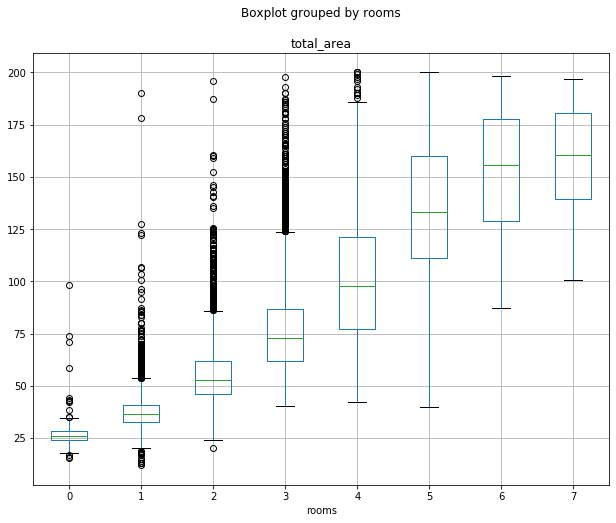

In [150]:
#диаграммы размаха площади в зависимости от количества комнат
data.boxplot(column='total_area', by='rooms', figsize = (10,8))

Границы, судя по гистограмме и ящикам, у нас будут такие:
от 0 до 40 квадратных метров (основная часть однушек, первый квартиль и скачок на гистограмме), от 40 до 69 (чуть выше границы между двушками и трешками, третий квартиль), от 69 до 120 (большая часть трешек) и все, что больше 120.

In [151]:
#функция для деления площади на категории
def quantile (num):
    if num < 40:
        return 1
    elif num < 69:
        return 2
    elif num < 120:
        return 3
    return 4


#новый столбец с категориями площадей
data['total_area_category'] = data['total_area'].apply(quantile)
data.head()

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,year,month,weekday,floor_category,living_ratio,kitchen_ratio,total_area_category
0,1564812,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,NaN,False,108.00,False,25.00,0,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,95,120370.37,2019,3,3,Другой,0.47,0.23,3
1,NaN,7,3350000.00,40.40,2018-12-04,1,2.65,11,18.60,1,NaN,False,40.40,False,11.00,2,посёлок Шушары,12817.00,18603.00,0.00,0.00,0.00,0.00,81,82920.79,2018,12,1,Первый,0.46,0.27,2
2,Сталинский,10,5196000.00,56.00,2015-08-20,2,2.65,5,34.30,4,NaN,False,56.00,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558,92785.71,2015,8,3,Другой,0.61,0.15,2
3,NaN,0,64900000.00,159.00,2015-07-24,3,2.65,14,91.73,9,NaN,False,159.00,False,27.82,0,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424,408176.10,2015,7,4,Другой,0.58,0.17,4
4,NaN,2,10000000.00,100.00,2018-06-19,2,3.03,14,32.00,13,NaN,False,100.00,False,41.00,0,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121,100000.00,2018,6,1,Другой,0.32,0.41,3


In [152]:
#общее количество квартир с категорией площади
data_area = data.pivot_table(index = 'total_area_category', values = 'rooms', aggfunc = 'count')
#переименование столбцов
data_area.set_axis(['total'], axis = 1, inplace = True)
#переименование строк
data_area.set_axis(['площадь менее 40 кв.м', 'площадь от 40 до 69 кв.м', 'площадь от 69 до 120 кв.м', 
                        'площадь более 120 кв.м'], axis = 0, inplace = True)
#процент квартир с категорией площади от общего числа квартир
data_area['percent_total'] = data_area['total']/(data_area['total'].sum())

data_area

,total,percent_total
площадь менее 40 кв.м,5702,0.24
площадь от 40 до 69 кв.м,11850,0.51
площадь от 69 до 120 кв.м,4984,0.21
площадь более 120 кв.м,867,0.04


In [153]:
#общее количество квартир с разным количеством комнат
data_room = data.pivot_table(index = 'rooms', values = 'total_area', aggfunc = 'count')
data_room['percent_total'] = data_room['total_area']/(data_room['total_area'].sum())
data_room

,total_area,percent_total
rooms,,
0,196,0.01
1,8014,0.34
2,7918,0.34
3,5788,0.25
4,1140,0.05
5,265,0.01
6,62,0.00
7,20,0.00


Результаты довольно ровные. Половина всего массива данных приходится на квартиры с площадью от 40 до 69 кв.м, и еще по четверти - на очень маленькие и большие квартиры. 
Квартир больше 120 кв.м. на рынке представлено совсем мало.
По трети квартир приходится на однокомнатные и двухкомнатные квартиры, еще четверть - на трехкомнатные, остальных вариантов очень мало.

## Cоотношение жилой, кухонной и общей площади квартир  <a name="4.2"></a>

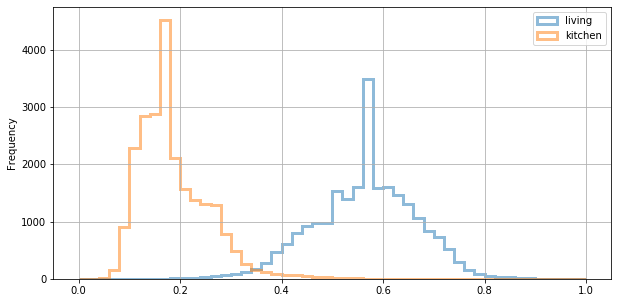

In [154]:
#соотношение кухонной и общей площади и соотношение жилой и общей площади

ax = data.plot(kind='hist', y='living_ratio', histtype='step', range=(0, 1), 
               bins=50, linewidth=3, alpha=0.5, figsize = (10,5), label='living')
data.plot(kind='hist', y='kitchen_ratio', histtype='step', range=(0, 1), 
          bins=50, linewidth=3, alpha=0.5, figsize = (10,5), label='kitchen', ax=ax, grid=True, legend=True)

Выбивающиеся столбцы на гистограммах - это медианы, которыми были заполнены пропущенные значения. Странные параметры: жилая площадь менее трети от общей и кухня больше половины от общей. Можно срезать примерно по усам ящиков. Категоризировать не будем, это вряд ли понадобится потом.
При удалении будем сравнивать ррезультаты работы метода describe до и после удаления, чтобы не сместить выборку.

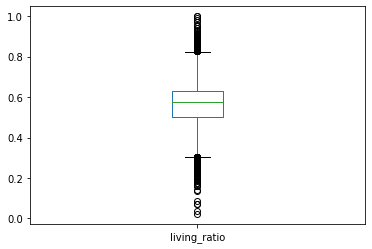

In [155]:
#ящик с усами для жилой площади
data['living_ratio'].plot.box()

In [156]:
data['living_ratio'].describe()

count   23403.00
mean        0.56
std         0.10
min         0.02
25%         0.50
50%         0.58
75%         0.63
max         1.00
Name: living_ratio, dtype: float64

In [157]:
#удаление строк в соответствии с логическим условием
data.drop((data[data['living_ratio'] < 0.3]).index, inplace = True)
data.drop((data[data['living_ratio'] > 0.9]).index, inplace = True)

data['living_ratio'].describe()

count   23201.00
mean        0.57
std         0.10
min         0.30
25%         0.50
50%         0.58
75%         0.63
max         0.90
Name: living_ratio, dtype: float64

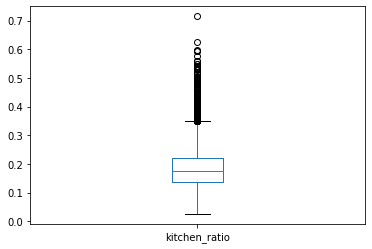

In [158]:
#ящик с усами для кухонной площади
data['kitchen_ratio'].plot.box()

In [159]:
data['kitchen_ratio'].describe()

count   23201.00
mean        0.19
std         0.07
min         0.03
25%         0.14
50%         0.17
75%         0.22
max         0.72
Name: kitchen_ratio, dtype: float64

In [160]:
#удаление строк в соответствии с логическим условием
data.drop((data[data['kitchen_ratio'] > 0.4]).index, inplace = True)
data['kitchen_ratio'].describe()

count   23028.00
mean        0.18
std         0.06
min         0.03
25%         0.14
50%         0.17
75%         0.22
max         0.40
Name: kitchen_ratio, dtype: float64

## Стоимость квартир и стоимость квадратного метра  <a name="4.3"></a>

Общая стоимость квартиры и стоимость квадратного метра - основные параметры объявлений за квартиру. Нужно удалить выбивающиеся значения. Категоризировать данные при этом особого смысла нет, интереснее смотреть на графики корреляции целиком.
Чтобы увидеть распределение цен, посмотри на ящики с усами и на гистограммы; при удалении выбивающихся значений будем сравнивать результаты работы метода describe, чтобы не исказить выборку.

In [161]:
data['last_price'].describe()

count       23028.00
mean      5973003.05
std       6092465.99
min        430000.00
25%       3400000.00
50%       4600000.00
75%       6650000.00
max     330000000.00
Name: last_price, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000249DD34A248>]],
      dtype=object)

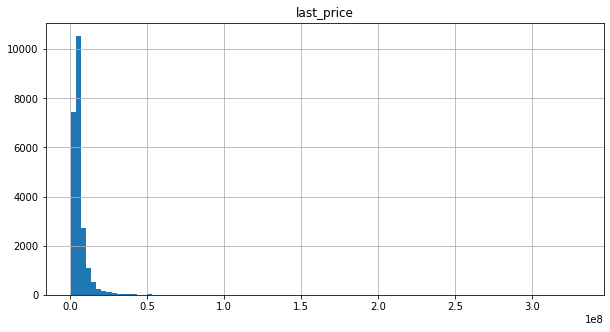

In [162]:
#гистограмма цен на квартиру
data.hist('last_price', bins = 100, figsize = (10,5))

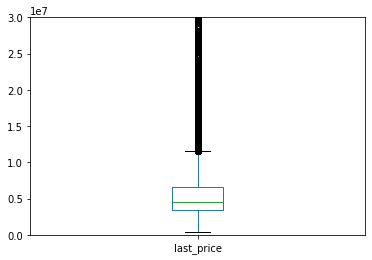

In [163]:
#ящик с усами
plt.ylim(0, 30000000)
data['last_price'].plot.box()

In [164]:
data.query('last_price > 30000000')['last_price'].count()

165

In [165]:
#удаление строк в соответствии с логическим условием
data.drop((data[data['last_price'] > 30000000]).index, inplace = True)
data['last_price'].describe()

count      22863.00
mean     5656069.71
std      3876957.57
min       430000.00
25%      3400000.00
50%      4599000.00
75%      6590000.00
max     30000000.00
Name: last_price, dtype: float64

Квартир стоимостью больше 30 млн руб менее одного процента. Медиана после удаления осталась почти на том же месте - в 4,6 млн, а среднее приблизилось к ней - с 6 млн до 5,6 млн руб.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000249DDF25D88>]],
      dtype=object)

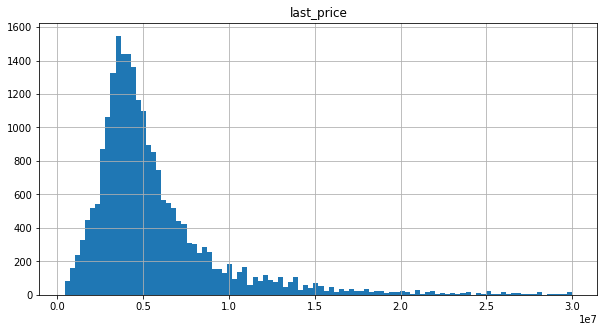

In [166]:
#новая гистограмма цен на квартиру
data.hist('last_price', bins = 100, figsize = (10,5))

In [167]:
data['meter_price'].describe()

count    22863.00
mean     96002.13
std      35565.54
min       7962.96
25%      76040.22
50%      94324.32
75%     112870.80
max     848484.85
Name: meter_price, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000249DDF9F088>]],
      dtype=object)

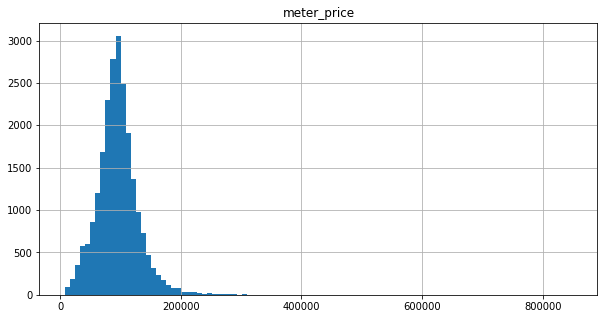

In [168]:
#гистограмма распределения цен за квадратный метр
data.hist('meter_price', bins = 100, figsize = (10,5))

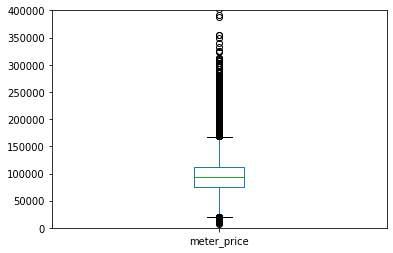

In [169]:
#ящик с усами
plt.ylim(0, 400000)
data['meter_price'].plot.box()

Есть одновременно и слишком маленькие, и слишком большие значения, но если срезать примерно по усам ящика - потеряется слишком много. Я подобрала значения, по которым решила срезать выбивающиеся строки, глядя на график корреляции цены и общей площади.

In [170]:
#удаление строк в соответствии с логическим условием
data.drop((data[data['meter_price'] < 20000]).index, inplace = True)
data.drop((data[data['meter_price'] > 300000]).index, inplace = True)

data['meter_price'].describe()

count    22678.00
mean     96287.35
std      33430.53
min      20000.00
25%      76584.99
50%      94545.45
75%     112940.53
max     300000.00
Name: meter_price, dtype: float64

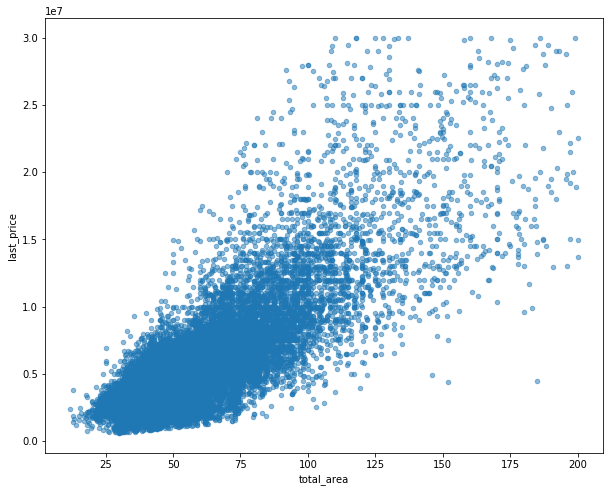

In [171]:
#график корреляции цены и общей площади, на котором уменьшился разброс
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.5, figsize = (10,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000249E041C508>]],
      dtype=object)

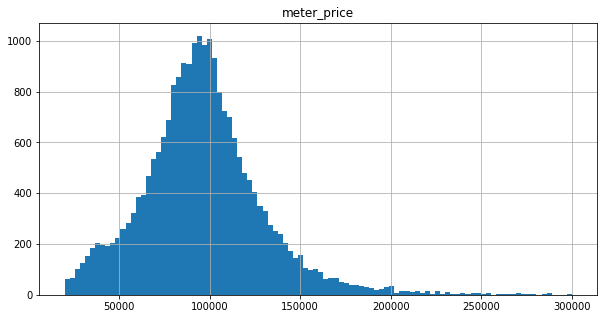

In [172]:
#новая гистограмма распределения цен за квадратный метр
data.hist('meter_price', bins = 100, figsize = (10,5))

In [173]:
#посмотрим на матрицу корреляции, чтобы узнать, какие параметры влияют на цену
corr = data.corr()
#надо покрасить, чтобы было понятнее
corr.style.background_gradient(cmap = 'coolwarm')

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,area,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,year,month,weekday,living_ratio,kitchen_ratio,total_area_category
total_images,1.000000,0.154130,0.111260,0.092984,0.004496,0.020483,0.097601,0.033755,-0.028120,0.111260,-0.022004,0.096949,0.051094,-0.001950,-0.040012,0.011795,0.012523,-0.018354,-0.014827,-0.042891,0.142634,0.145698,0.004263,-0.009323,0.003561,-0.022840,0.113817
last_price,0.154130,1.000000,0.799375,0.512547,0.105210,0.080904,0.702917,0.083531,-0.054874,0.799375,-0.035655,0.645662,0.034270,-0.032482,-0.347761,0.176389,0.149982,0.188177,0.048590,0.093128,0.670229,-0.032999,0.006790,-0.016176,0.029518,-0.136632,0.683781
total_area,0.111260,0.799375,1.000000,0.797527,0.100649,-0.045515,0.939377,-0.019038,-0.094688,1.000000,-0.055817,0.641043,0.033532,-0.023243,-0.224307,0.132159,0.091679,0.146776,0.043377,0.122817,0.157698,-0.078396,0.008196,-0.013137,0.199691,-0.368201,0.889447
rooms,0.092984,0.512547,0.797527,1.000000,0.053735,-0.219682,0.870072,-0.154709,-0.159108,0.797527,-0.094070,0.284998,-0.006279,-0.054107,-0.157794,0.106885,0.049337,0.074150,0.018549,0.091717,-0.066177,-0.047807,-0.004965,-0.004959,0.521719,-0.615039,0.778336
ceiling_height,0.004496,0.105210,0.100649,0.053735,1.000000,-0.025624,0.093644,-0.016290,-0.000503,0.100649,0.025869,0.077003,0.015201,-0.032333,-0.096008,0.069252,0.034246,0.071366,0.009801,0.017601,0.065145,-0.001954,-0.001238,-0.007667,0.006473,-0.012381,0.090331
floors_total,0.020483,0.080904,-0.045515,-0.219682,-0.025624,1.000000,-0.156031,0.663858,0.065366,-0.045515,0.048101,0.194281,0.174672,0.104912,0.004483,-0.243524,-0.122414,-0.113041,-0.038521,-0.035562,0.258126,0.006924,0.018595,0.012783,-0.367927,0.352133,-0.073167
living_area,0.097601,0.702917,0.939377,0.870072,0.093644,-0.156031,1.000000,-0.103071,-0.070131,0.939377,-0.040819,0.437798,0.002454,-0.048077,-0.216145,0.147677,0.081844,0.129813,0.039338,0.113069,0.072274,-0.068316,-0.000191,-0.010849,0.492398,-0.542674,0.845944
floor,0.033755,0.083531,-0.019038,-0.154709,-0.016290,0.663858,-0.103071,1.000000,0.035736,-0.019038,0.031402,0.147169,0.169808,0.069599,0.002696,-0.158971,-0.075778,-0.071747,-0.021923,-0.030775,0.203699,0.004655,0.020291,0.011193,-0.271317,0.246055,-0.045403
studio,-0.028120,-0.054874,-0.094688,-0.159108,-0.000503,0.065366,-0.070131,0.035736,1.000000,-0.094688,-0.004152,-0.090152,0.028053,-0.022896,-0.007829,-0.031037,-0.020774,-0.000587,0.004051,-0.018756,0.031288,0.012050,0.002281,-0.000595,0.091631,-0.010978,-0.102012
area,0.111260,0.799375,1.000000,0.797527,0.100649,-0.045515,0.939377,-0.019038,-0.094688,1.000000,-0.055817,0.641043,0.033532,-0.023243,-0.224307,0.132159,0.091679,0.146776,0.043377,0.122817,0.157698,-0.078396,0.008196,-0.013137,0.199691,-0.368201,0.889447


По матрице корреляции хорошо видно, какие параметры оказывают наибольшее влияние на цену квартиры: общая, жилая и кухонная площади и количество комнат. Еще видна не настолько сильная, но имеющая значение отрицательная корреляция с расстоянием от центра: чем дальше, тем дешевле. Она даже больше видна на ячейке с категорией местоположения. 
Никакой связи с расстоянием от аэропорта нет; наличие парков или водоемов играет роль, но не значительную.

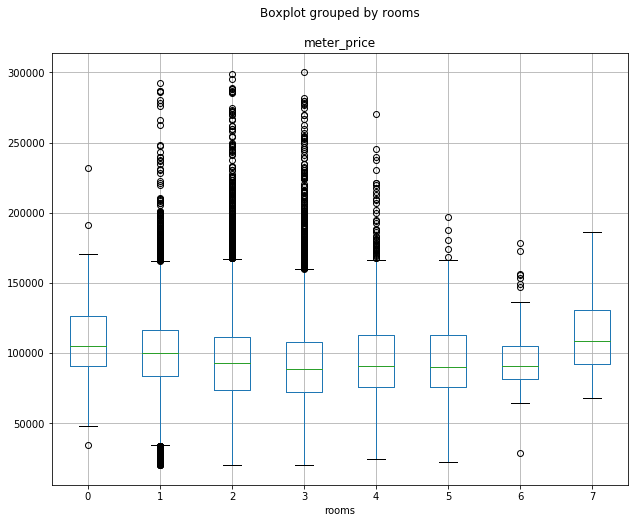

In [174]:
#посмотрим, какая цена за квадратный метр какому количеству комнат соответствует
data.boxplot(column='meter_price', by='rooms', figsize = (10,8))

In [175]:
#медианные цены за квадратный метр в квартирах с разным количеством комнат в зависимости от этажа
data_floor = data.pivot_table(index = 'floor_category', values = 'meter_price', columns = 'rooms', aggfunc = 'median')
data_floor

rooms,0,1,2,3,4,5,6,7
floor_category,,,,,,,,
Другой,105583.06,102102.80,97285.01,91554.64,92857.14,91666.67,89765.92,115778.76
Первый,94625.78,90268.46,78973.68,78404.40,77112.90,83826.43,113207.55,156250.00
Последний,110142.86,92903.23,83333.33,85153.58,95000.00,84963.54,87998.80,92788.00


По данным ящиков и медиан цен за квадратный метр для разных этажей и разного количества комнат можно сказать следующее:
- Интересно, что цена за квадратный метр выше для квартир, где нет комнат (апартаменты и квартиры со свободной планировкой), и для однокомнатных квартир
- Цена за квадратный метр для квартир с большим количеством комнат (5 и больше) растет - это в среднем большие квартиры, цена которых выше не только из-за метража
- Цены на квадратный метр за квартиры на первом и последнем этажах в среднем меньше, чем на квартиры на любых других этажах, при этом на цены на первый этаж еще меньше, чем цены на последний.

## Расстояние от центра и аэропорта  <a name="4.4"></a>

У обоих параметров должен быть предсказуемый разброс (70-80 км для расстояния для аэропорта и до 50-60 км от центра Питера. При этом расстояние от аэропорта, как мы видели по матрице корреляции, не оказывает влияния на цену квартиры, а вот расстояние от центра - оказывает, хоть и не такое значительное, как, например, площадь и количество комнат.
Посмотрим на гистограммы распределения расстояний от центра и аэропорта.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000249DE166DC8>]],
      dtype=object)

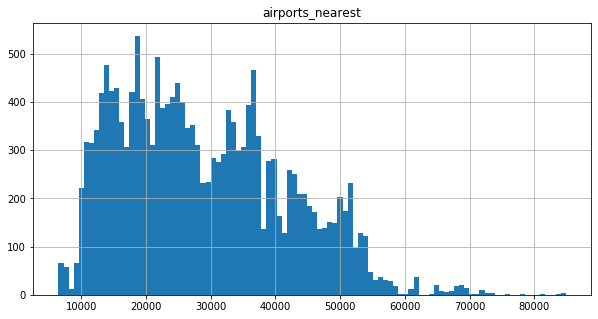

In [176]:
data.hist('airports_nearest', bins = 100, figsize = (10,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000249E25E7648>]],
      dtype=object)

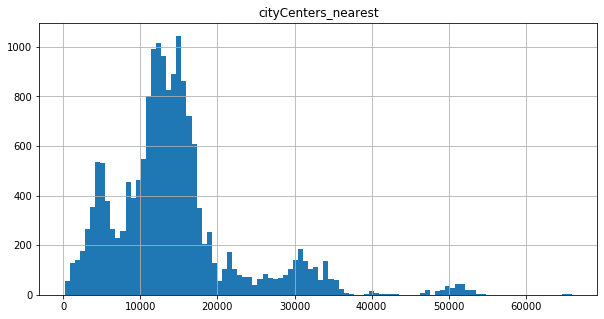

In [177]:
data.hist('cityCenters_nearest', bins = 100, figsize = (10,5))

Вот это городские данные как они есть. Весь этот датасет очень много теряет без координат или хотя бы адресов, но гистограмма с расстоянием от центра наглядно показывает распределение плотности населения. Первый, менее значительный пик - это квартиры более-менее в центре, а провал в районе 7-8 км от центра приходится на железнодорожное кольцо. Потом идет высокий пик высокой плотности населения в микрорайонах, которая резко падает примерно после КАД. Есть еще третий, в районе 30 км от центра - это пригороды вроде Пушкина, Всеволожска или Колпино.
С расстояниями от аэропорта тоже все логично - в пределах 5 км от него почти нет жилья, зато в пределах 15-20 км от него умещается две трети Питера.

Расстояние от аэропорта делить на категории и использовать потом не будем, а категории для расстояния от центра пусть будут такие - менее 7500 (центр), менее 17500 (микрорайоны), менее 35000 (пригороды) и остальное - периферия. Можно было бы точнее поделить центр, отделив самые предположительно дорогие районы, но для этого надо точно знать, что точка центра была на Дворцовой площади (а лучше иметь координаты).

In [178]:
#функция для деления квартир по местоположению
#записываем цифрами, чтобы можно было потом работать с этим
def position_foo (num):
    if num != num:
        return 0
    elif num < 7500:
        return 4
    elif num < 17500:
        return 3
    elif num < 35000:
        return 2
    return 1

#новый столбец с категориями местоположения
data['place_category'] = data['cityCenters_nearest'].apply(position_foo)
data.head(10)

,building_series_id,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,area,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,year,month,weekday,floor_category,living_ratio,kitchen_ratio,total_area_category,place_category
0,1564812,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,NaN,False,108.00,False,25.00,0,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,95,120370.37,2019,3,3,Другой,0.47,0.23,3,3
1,NaN,7,3350000.00,40.40,2018-12-04,1,2.65,11,18.60,1,NaN,False,40.40,False,11.00,2,посёлок Шушары,12817.00,18603.00,0.00,0.00,0.00,0.00,81,82920.79,2018,12,1,Первый,0.46,0.27,2,2
2,Сталинский,10,5196000.00,56.00,2015-08-20,2,2.65,5,34.30,4,NaN,False,56.00,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558,92785.71,2015,8,3,Другой,0.61,0.15,2,3
5,NaN,10,2890000.00,30.40,2018-09-10,1,2.65,12,14.40,5,NaN,False,30.40,False,9.10,0,городской посёлок Янино-1,nan,nan,nan,nan,nan,nan,55,95065.79,2018,9,0,Другой,0.47,0.30,1,0
7,NaN,5,7915000.00,71.60,2019-04-18,2,2.65,24,41.31,22,NaN,False,71.60,False,18.90,2,Санкт-Петербург,23982.00,11634.00,0.00,0.00,0.00,0.00,95,110544.69,2019,4,3,Другой,0.58,0.26,3,3
8,NaN,20,2900000.00,33.16,2018-05-23,1,2.65,27,15.43,26,NaN,False,33.16,False,8.81,0,посёлок Мурино,nan,nan,nan,nan,nan,nan,189,87454.76,2018,5,2,Другой,0.47,0.27,1,0
9,NaN,18,5400000.00,61.00,2017-02-26,3,2.50,9,43.60,7,NaN,False,61.00,False,6.50,2,Санкт-Петербург,50898.00,15008.00,0.00,0.00,0.00,0.00,289,88524.59,2017,2,6,Другой,0.71,0.11,2,3
10,NaN,5,5050000.00,39.60,2017-11-16,1,2.67,12,20.30,3,NaN,False,39.60,False,8.50,0,Санкт-Петербург,38357.00,13878.00,1.00,310.00,2.00,553.00,137,127525.25,2017,11,3,Другой,0.51,0.21,1,3
11,NaN,9,3300000.00,44.00,2018-08-27,2,2.65,5,31.00,4,False,False,44.00,False,6.00,1,Ломоносов,48252.00,51677.00,0.00,0.00,0.00,0.00,7,75000.00,2018,8,0,Другой,0.70,0.14,2,1
12,NaN,10,3890000.00,54.00,2016-06-30,2,2.65,5,30.00,5,NaN,False,54.00,False,9.00,0,Сертолово,nan,nan,nan,nan,nan,nan,90,72037.04,2016,6,3,Последний,0.56,0.17,2,0


Теперь, когда у нас есть категории для расстояния от центра, можно посмотреть на зависимости цены от них. Проще всего это сделать через медианы в сводной таблице (для всех квартир в целом и для квартир с разной категорией площади), но еще интересно увидеть график корреляции площадь-цена, который уже был в предыдущем разделе, с различением по местоположению.

In [179]:
#медианные цены за квадратный метр в квартирах с разным местоположением
data_place = data.pivot_table(index = 'place_category', values = 'meter_price', aggfunc = 'median')
#медианные цены за квадратный метр в квартирах с разной площадью с разным местоположением
data_place2 = data.pivot_table(index = 'place_category', values = 'meter_price', columns = 'total_area_category', aggfunc = 'median')
#объединение таблиц и переименование столбцов и строк
data_place_total = data_place.join(data_place2)
data_place_total.set_axis(['по всем квартирам','площадь менее 40 кв.м', 'площадь от 40 до 69 кв.м', 'площадь от 69 до 120 кв.м', 
                        'площадь более 120 кв.м'], axis = 1, inplace = True)
data_place_total.set_axis(['нет данных','периферия','пригороды', 'микрорайоны', 'центр'], axis = 0, inplace = True)
data_place_total

,по всем квартирам,площадь менее 40 кв.м,площадь от 40 до 69 кв.м,площадь от 69 до 120 кв.м,площадь более 120 кв.м
нет данных,61000.93,72972.97,56489.26,60000.00,69663.95
периферия,79487.18,82410.14,77227.72,83561.64,63600.00
пригороды,86046.51,93333.33,83138.17,78199.05,100000.00
микрорайоны,102272.73,109076.70,98037.56,104005.72,122023.81
центр,119322.09,136305.21,123584.91,112412.18,112018.54


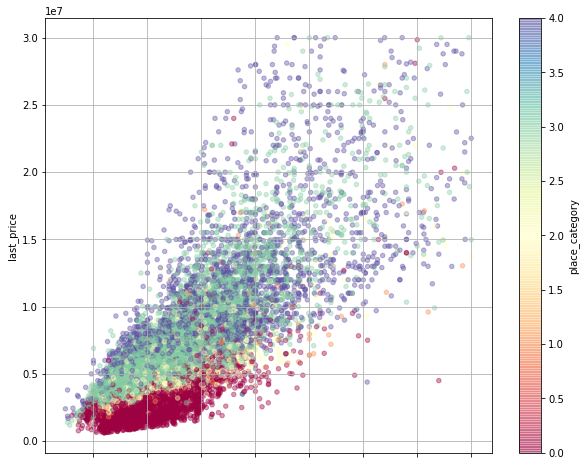

In [180]:
#корреляция площади и цены, цвет меняется в зависимости от категории местоположения
data.plot(x='total_area', y='last_price', kind='scatter', c = 'place_category', colormap='Spectral', grid = True, alpha=0.4, figsize = (10,8))

По медианам стоимости квадратного метра за все квартиры и квартиры с разной площадью видно, что чем ближе к центру - тем дороже. Разница в цене у такого жилья с квартирами в центре может составлять до 100%, а темп роста цены примерно одинаковый для всех категорий площади.

По графику корреляции тоже очень хорошо видна зависимость стоимости квартир от местоположения.
Квартиры, находящиеся в центре, имеют наибольший разброс по цене и площади, в то время как квартиры в пригороде и на периферии зачастую дешевы и меньше размером. Это, кстати, довольно точно отражает ситуацию с новостройками, которые строятся за границами города в огромных количествах и имеют типовые параметры - это дешевое массовое жилье. 

In [181]:
#количество квартир с разным местоположением
data_place_count = data.pivot_table(index = 'place_category', values = 'meter_price', aggfunc = 'count')
#переименование строк
data_place_count.set_axis(['нет данных','периферия','пригороды', 'микрорайоны', 'центр'], axis = 0, inplace = True)
data_place_count

,meter_price
нет данных,5258
периферия,417
пригороды,2943
микрорайоны,10974
центр,3086


## Квартиры в пригородах  <a name="4.4.1"></a>

Посмотрим, как отличается цена за квадратный метр в пригородах от цены за квадратный метр в Питере, для этого отберем десять населенных пунктов.

In [182]:
#найдем 10 населенных пунктов в пригороде
data['locality_name'].value_counts()

Санкт-Петербург       15005
посёлок Мурино          507
деревня Кудрово         451
посёлок Шушары          433
Всеволожск              390
                      ...  
поселок Рабитицы          1
деревня Снегирёвка        1
деревня Меньково          1
поселок Лисий Нос         1
деревня Мануйлово         1
Name: locality_name, Length: 338, dtype: int64

In [183]:
#составим их список в качестве внешней переменной, добавим Санкт-Петербург, чтобы было с чем сравнивать
list_names = ['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск', 'Пушкин', 'Колпино', 'посёлок Парголово', 'Гатчина', 
              'деревня Кудрово', 'Выборг', 'Петергоф']
#выборка по внешнему списку
data_places = data.query('locality_name in @list_names')
data_places['locality_name'].value_counts()

Санкт-Петербург      15005
посёлок Мурино         507
деревня Кудрово        451
посёлок Шушары         433
Всеволожск             390
Пушкин                 353
Колпино                334
посёлок Парголово      316
Гатчина                297
Выборг                 234
Петергоф               199
Name: locality_name, dtype: int64

In [184]:
#медианные цены за квадратный метр в пригородах
data_places_final = data_places.pivot_table(index = 'locality_name', values = 'meter_price', aggfunc = 'median')
#сортировка по значениям цены за квадратный метр
data_places_final.sort_values(by = 'meter_price', inplace = True)
data_places_final

,meter_price
locality_name,
Выборг,58357.39
Всеволожск,65667.56
Гатчина,67695.96
Колпино,74729.19
посёлок Шушары,76666.67
Петергоф,82142.86
посёлок Мурино,85657.14
посёлок Парголово,91378.49
деревня Кудрово,95820.19


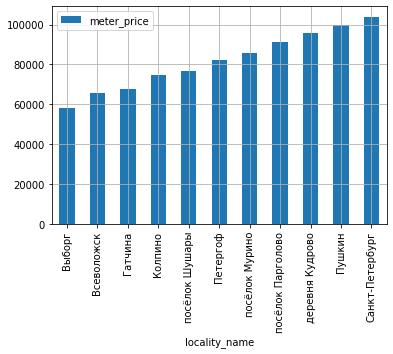

In [185]:
data_places_final.plot(kind = 'bar', grid = True)

В среднем цена квадратного метра в пригородах ниже, чем в Петербурге. Есть и исключения: Пушкин находится в границах Петербурга, и недвижимость там почти такая же дорогая, та же ситуация с Парголово; Кудрино хоть и за административной границей, но находится внутри КАД.
Напротив, Выборг, Всеволожск и Гатчина находятся дальше, и цена за квадратный метр там ниже, чем в Петербурге, почти на сорок процентов.

## Даты размещения объявления и длительность процесса продажи  <a name="4.5"></a>

Прежде чем смотреть на то, зависит ли цена на квадратный метр от года/месяца/дня недели публикации объявления, удалим выбивающиеся значения со слишком длинным значением в колонке *days_exposition*.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000249E23D3648>]],
      dtype=object)

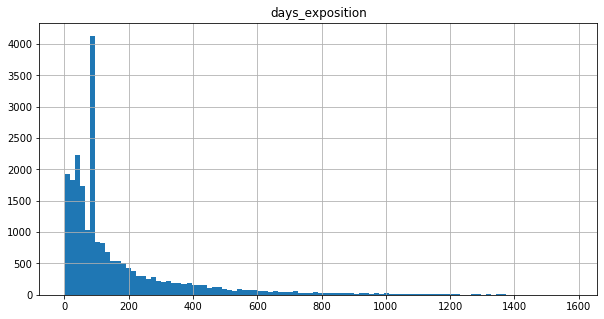

In [186]:
data.hist('days_exposition', bins = 100, figsize = (10,5))

In [187]:
data['days_exposition'].describe()

count   22678.00
mean      168.11
std       204.96
min         1.00
25%        45.00
50%        95.00
75%       197.00
max      1580.00
Name: days_exposition, dtype: float64

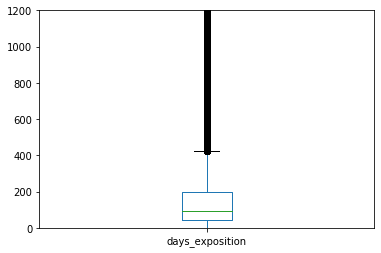

In [188]:
#ящик с усами
plt.ylim(0, 1200)
data['days_exposition'].plot.box()

Пик перед 100 - это медиана, которой были заполнены пропущеннные значения.
Какой-то очень длинный хвост у данных, квартиры больше трех-четырех лет висят в продаже. Можно убрать все, что больше 1000, медиана от этого не изменится.
Интересно, что много маленьких значений. Но это, наверное, объясняется тем, что это квартиры, которые были выставлены на продажу недавно и попали в выгрузку на какую-то дату.

In [189]:
#удаление строк в соответствии с логическим условием
data.drop((data[data['days_exposition'] > 1000]).index, inplace = True)
data['days_exposition'].describe()

count   22422.00
mean      156.68
std       175.27
min         1.00
25%        45.00
50%        95.00
75%       190.00
max      1000.00
Name: days_exposition, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000249E23BF888>]],
      dtype=object)

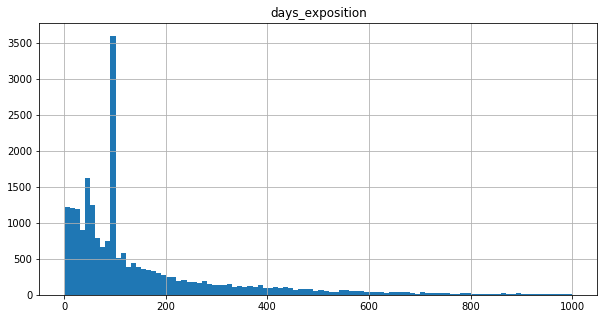

In [190]:
data.hist('days_exposition', bins = 100, figsize = (10,5))

In [191]:
#медианные цены за квадратный метр в квартирах с разной площадью в зависимости от года публикации
data_year = data.pivot_table(index = 'year', values = 'meter_price', columns = 'total_area_category', aggfunc = 'median')
data_year

total_area_category,1,2,3,4
year,,,,
2014,106467.90,100248.13,106344.09,131334.59
2015,96609.20,88322.19,92857.14,120532.53
2016,96604.94,85886.32,94638.39,103927.34
2017,96225.07,86956.52,96376.33,111148.37
2018,100000.00,91816.93,97698.00,115000.00
2019,112325.00,98506.51,104072.84,119202.90


In [192]:
#медианные цены за квадратный метр в квартирах с разным количеством комнат в зависимости от года публикации
data_year2 = data.pivot_table(index = 'year', values = 'meter_price', columns = 'rooms', aggfunc = 'median')
data_year2

rooms,0,1,2,3,4,5,6,7
year,,,,,,,,
2014,nan,116059.53,82316.12,110047.04,119750.34,120578.78,nan,nan
2015,81785.71,99118.94,89600.00,87242.08,92114.45,93569.24,88383.43,nan
2016,100207.04,97700.85,88888.89,85164.84,88948.63,82914.63,75558.48,157059.09
2017,102611.11,97184.59,89130.43,86970.32,87755.10,88766.98,87878.79,105263.16
2018,105334.46,100328.95,94262.30,89266.51,89767.83,95059.26,98319.33,86767.90
2019,116000.00,112230.22,101960.78,95139.91,97831.32,90909.09,99411.76,108536.59


In [193]:
#медианные цены за квадратный метр в квартирах с разной площадью в зависимости от месяца публикации
data_month = data.pivot_table(index = 'month', values = 'meter_price', columns = 'total_area_category', aggfunc = 'median')
data_month

total_area_category,1,2,3,4
month,,,,
1,98003.59,90266.11,101009.10,114476.10
2,99455.04,89678.23,98840.03,108004.85
3,101608.59,90510.85,95942.98,107279.69
4,101626.12,91406.25,98343.69,116666.67
5,96572.32,88411.19,93720.77,103473.23
6,97383.72,87837.22,97926.27,104645.00
7,100000.00,89361.70,95000.00,116556.29
8,100613.91,90732.26,100000.00,110359.32
9,98422.75,91071.43,99884.66,112430.72


In [194]:
#медианные цены за квадратный метр в квартирах с разной площадью в зависимости от дня недели публикации
data_weekday = data.pivot_table(index = 'weekday', values = 'meter_price', columns = 'total_area_category', aggfunc = 'median')
data_weekday

total_area_category,1,2,3,4
weekday,,,,
0,100000.00,90531.56,95744.68,116954.73
1,98437.50,90609.56,98865.98,107500.00
2,99686.83,90132.38,99226.80,116027.34
3,98125.00,90276.00,98019.80,114148.46
4,99740.56,89498.61,97182.54,109692.86
5,100000.00,89430.89,95180.72,107613.81
6,100313.48,88524.59,96219.49,111603.86


По связи цены за квадратный метр и даты размещения объявления можно сказать следующее. Данные по годам интересные: это данные о кризисе в стране. Почти за все категории площадей и за квартиры с любым количеством комнат упала медианная цена после 2014 года, и до сих пор не вернулась к изначальному уровню.
О данных по месяцам или дням недели такого сказать нельзя: медиана меняется не очень значительно.

## Студии, апартаменты и квартиры со свободной планировкой <a name="4.6"></a>

In [195]:
#выборка студий, апартаментов и квартир свободной планировки
data_studio = data.query('studio == True or open_plan == True or is_apartment == True')
data_studio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 144 to 23637
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   building_series_id    38 non-null     object        
 1   total_images          247 non-null    int64         
 2   last_price            247 non-null    float64       
 3   total_area            247 non-null    float64       
 4   first_day_exposition  247 non-null    datetime64[ns]
 5   rooms                 247 non-null    int64         
 6   ceiling_height        247 non-null    float64       
 7   floors_total          247 non-null    int64         
 8   living_area           247 non-null    float64       
 9   floor                 247 non-null    int64         
 10  is_apartment          63 non-null     object        
 11  studio                247 non-null    bool          
 12  area                  247 non-null    float64       
 13  open_plan       

In [196]:
#матрица корреляции для выборки студий, апартаментов и квартир свободной планировки
corr_studio = data_studio.corr()
corr_studio.style.background_gradient(cmap = 'coolwarm')

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,area,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,year,month,weekday,living_ratio,kitchen_ratio,total_area_category,place_category
total_images,1.000000,0.244932,0.254204,0.223564,-0.013357,-0.063482,0.236959,-0.029534,-0.116535,0.254204,-0.101072,0.239746,0.161682,-0.095529,0.070394,-0.027601,-0.114998,-0.063281,-0.170738,0.057066,0.126879,0.104947,-0.007477,0.140953,-0.062995,0.093905,0.231702,0.130690
last_price,0.244932,1.000000,0.800333,0.621752,0.033159,-0.333250,0.780855,-0.142515,-0.303627,0.800333,-0.147132,0.607303,0.022796,0.126027,-0.078071,0.371619,0.099857,0.231459,-0.001324,0.081544,0.500228,0.112948,0.027576,-0.092921,-0.181841,-0.043045,0.784458,0.343689
total_area,0.254204,0.800333,1.000000,0.808758,0.123896,-0.434294,0.948677,-0.237250,-0.415494,1.000000,-0.127236,0.877284,0.065979,0.207764,0.074917,0.208315,-0.020692,0.122420,0.039917,0.014352,0.010240,0.122490,-0.024751,-0.014669,-0.281351,0.091911,0.956562,0.114901
rooms,0.223564,0.621752,0.808758,1.000000,0.173309,-0.422921,0.777452,-0.233987,-0.453864,0.808758,-0.114360,0.700367,0.061676,0.163571,0.061887,0.333434,0.023475,0.182549,0.002480,0.001487,-0.023699,-0.000464,-0.093334,-0.061549,-0.225559,0.069254,0.787448,0.089923
ceiling_height,-0.013357,0.033159,0.123896,0.173309,1.000000,-0.089050,0.162125,-0.031289,-0.147877,0.123896,0.011306,0.040685,-0.006740,0.037771,-0.082428,0.299724,0.086188,0.047219,0.083538,-0.055729,-0.022991,0.039491,0.012667,-0.022891,0.026317,-0.099197,0.108044,-0.052083
floors_total,-0.063482,-0.333250,-0.434294,-0.422921,-0.089050,1.000000,-0.406898,0.547776,0.208778,-0.434294,0.154625,-0.390915,0.186474,-0.162240,0.056505,-0.316301,-0.038591,-0.219855,-0.226157,0.075470,0.048008,-0.142869,-0.004383,0.059187,0.149092,-0.060344,-0.479778,-0.026185
living_area,0.236959,0.780855,0.948677,0.777452,0.162125,-0.406898,1.000000,-0.248160,-0.350404,0.948677,-0.101423,0.756394,0.012042,0.192452,0.017157,0.262426,0.007496,0.165146,0.020732,-0.011151,0.043081,0.101871,-0.019257,-0.012393,0.003331,-0.088748,0.895199,0.123972
floor,-0.029534,-0.142515,-0.237250,-0.233987,-0.031289,0.547776,-0.248160,1.000000,0.086309,-0.237250,0.114888,-0.209456,0.129314,-0.274984,0.033762,-0.162206,0.038021,-0.157535,-0.173840,0.105573,0.140374,-0.097068,0.034982,0.052977,0.002134,-0.018711,-0.260043,-0.033069
studio,-0.116535,-0.303627,-0.415494,-0.453864,-0.147877,0.208778,-0.350404,0.086309,1.000000,-0.415494,-0.677128,-0.411751,-0.154399,-0.208667,-0.158636,-0.212394,-0.024515,-0.119175,-0.105788,0.027457,0.052400,0.110261,-0.108758,-0.016427,0.259978,-0.189636,-0.427856,0.022358
area,0.254204,0.800333,1.000000,0.808758,0.123896,-0.434294,0.948677,-0.237250,-0.415494,1.000000,-0.127236,0.877284,0.065979,0.207764,0.074917,0.208315,-0.020692,0.122420,0.039917,0.014352,0.010240,0.122490,-0.024751,-0.014669,-0.281351,0.091911,0.956562,0.114901


Самый важный параметр, который влияет на цену студии - это все еще площадь (общая, жилая и кухонная). Интересно, что более выражена зависимость от количества комнат и жилой площади - но возможно, это из-за разницы в выборке.
Потерялась зависимость цены от близости к центру города: наверное, это тоже результат того, что изменилась выборка. Зато усилилась положительная корреляция цены и количества парков вокруг.
Каких-то принципиальных отличий от обычных квартир не видно.

# Общие выводы <a name="5"></a>

Самые важные параметры в объявлении на квартиру - это общая цена, цена за квадратный метр, площадь и количество комнат. 
Эти данные распределяются по массиву данных следующим образом: 
- Медианная общая цена за квартиру - 4,6 млн.руб;
- Медианная цена за квадратный метр - 94 тыс.руб,
- Половина всего массива данных приходится на квартиры с площадью от 40 до 69 кв.м, и еще по четверти - на очень маленькие и большие квартиры. Квартир больше 120 кв.м. на рынке представлено совсем мало.
- По трети квартир приходится на однокомнатные и двухкомнатные квартиры, еще четверть - на трехкомнатные, остальных вариантов очень мало.

Медианное значение длительности процесса продажи - 95 дней (три месяца).


Были убраны следующие объявления:
- квартиры площадью больше 200 кв.м.,
- квартиры с количеством комнат больше 7,
- квартиры общей стоимостью больше 30 млн.руб,
- квартиры со стоимостью квадратного метра меньше 20 и больше 300 тыс.руб,
- квартиры с долей жилой площади больше 0,9 и меньше 0,3,
- квартиры с долей кухонной площади больше 0,4,
- объявления, которые висели больше 1000 дней.

Всего на этих итерациях было потеряно примерно пять процентов строк, что несколько многовато.



По матрице корреляции видно, какие параметры оказывают наибольшее влияние на цену квартиры: общая, жилая и кухонная площади и количество комнат. Еще видна не настолько сильная, но имеющая значение отрицательная корреляция с расстоянием от центра: чем дальше, тем дешевле. Она даже больше видна на ячейке с категорией местоположения. Никакой связи с расстоянием от аэропорта нет; наличие парков или водоемов играет роль, но не значительную.

По данным ящиков и медиан цен за квадратный метр для разных этажей и разного количества комнат можно сказать следующее:
- Интересно, что цена за квадратный метр выше для квартир, где нет комнат (апартаменты и квартиры со свободной планировкой), и для однокомнатных квартир
- Цена за квадратный метр для квартир с большим количеством комнат (5 и больше) растет - это в среднем большие квартиры, цена которых выше не только из-за метража
- Цены на квадратный метр за квартиры на первом и последнем этажах в среднем меньше, чем на квартиры на любых других этажах, при этом на цены на первый этаж еще меньше, чем цены на последний.

По медианам стоимости квадратного метра за все квартиры и квартиры с разной площадью видно, что чем ближе к центру - тем дороже. Разница в цене у такого жилья с квартирами в центре может составлять до 100%, а темп роста цены примерно одинаковый для всех категорий площади.
По графику корреляции тоже очень хорошо видна зависимость стоимости квартир от местоположения. Квартиры, находящиеся в центре, имеют наибольший разброс по цене и площади, в то время как квартиры в пригороде и на периферии зачастую дешевы и меньше размером. Это, кстати, довольно точно отражает ситуацию с новостройками, которые строятся за границами города в огромных количествах и имеют типовые параметры - это дешевое массовое жилье.

По связи цены за квадратный метр и даты размещения объявления: данные по годам интересные - это данные о кризисе в стране. Почти за все категории площадей и за квартиры с любым количеством комнат упала медианная цена после 2014 года, и до сих пор не вернулась к изначальному уровню.
О данных по месяцам или дням недели такого сказать нельзя: медиана меняется не очень значительно.


В среднем цена квадратного метра в пригородах ниже, чем в Петербурге. Есть и исключения: Пушкин находится в границах Петербурга, и недвижимость там почти такая же дорогая, та же ситуация с Парголово; Кудрино хоть и за административной границей, но находится внутри КАД.
Напротив, Выборг, Всеволожск и Гатчина находятся дальше, и цена за квадратный метр там ниже, чем в Петербурге, почти на сорок процентов.


Самый важный параметр, который влияет на цену студии - это все еще площадь (общая, жилая и кухонная). Интересно, что более выражена зависимость от количества комнат и жилой площади - но возможно, это из-за разницы в выборке.
Потерялась зависимость цены от близости к центру города: наверное, это тоже результат того, что изменилась выборка. Зато усилилась положительная корреляция цены и количества парков вокруг.
Каких-то принципиальных отличий от обычных квартир не видно.